In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import argparse
import sys

from robot_data_loader import *
from humanoidrobot import *

parser = argparse.ArgumentParser(description='FastSLAM on Humanoid Robot')
parser.add_argument('-jp', '--joint-path', default='', type=str,
                    help='path to joint data')
parser.add_argument('-lp', '--lidar-path', default='', type=str,
                    help='path to lidar data')
parser.add_argument('-uf', '--update-frequency', default='', type=int,
                    help='Update every n data points')

def main(arg_string = ""):
    global args
    
    # if arg_string is empty then running from console
    if not arg_string:
        args = parser.parse_args()
    else:
        arg_list = arg_string.split()
        args = parser.parse_args(arg_list)
        
    # create dataloader object and robot object
    dataloader = RobotDataLoader(args.joint_path, args.lidar_path)
    robot = HumanoidRobot(sensor_head_dist = 0.15, head_body_dist = 0.33, 
                 floor_body_dist = 0.93, N_eff_threshold = 5)
    
    # customize the fastSLAM parameters
    robot.fastslam = FastSLAM(x_range = (-30,30), y_range = (-30,30), map_res = 0.06,
                 dtheta_res = 1, pos_sweep_ind = np.arange(-4,5,1), 
                 lidar_angles = np.arange(-135,135.25,0.25), lidar_range = (0.1,30),
                 lidar_sweep_ind = np.arange(-4,5,1), 
                 num_particles = 50, x_sigma = 0.001, y_sigma = 0.001, theta_sigma = 0.015)


    # Run FastSLAM
    x_path = [] #path output
    y_path = [] #path output
    data_length = len(dataloader)
    for i in range(data_length):
        sys.stdout.flush()
        sys.stdout.write('\rFastSLAM Progress: {}/{}'.format(i+1, data_length))
        (l_scan, l_pose_x, l_pose_y, l_pose_yaw, h_pitch, h_yaw, ts) = dataloader.get_item(i)
        if i == 0:
            robot.setup_map(l_scan, l_pose_x, l_pose_y, l_pose_yaw, h_pitch, h_yaw, ts)
            T_w2b_best = robot.predict(l_scan, l_pose_x, l_pose_y, l_pose_yaw, h_pitch, h_yaw, ts)            
            x_path.append(T_w2b_best[0,3])
            y_path.append(T_w2b_best[1,3])
        elif (i+1)%args.update_frequency == 0:
            T_w2b_best = robot.predict_and_update(l_scan, l_pose_x, l_pose_y, l_pose_yaw, h_pitch, h_yaw, ts)        
            x_path.append(T_w2b_best[0,3])
            y_path.append(T_w2b_best[1,3])
        else:
            T_w2b_best = robot.predict(l_scan, l_pose_x, l_pose_y, l_pose_yaw, h_pitch, h_yaw, ts)
    print("")
    print("FastSLAM Completed")
    return robot, x_path, y_path


In [2]:
# Run FastSLAM on Humanoid robot
arg_string = "--joint-path ../data/joint/train_joint0 --lidar-path ../data/lidar/train_lidar0 --update-frequency 100"
robot, x_path, y_path = main(arg_string)

Session Progress: 200/200
Session Completed


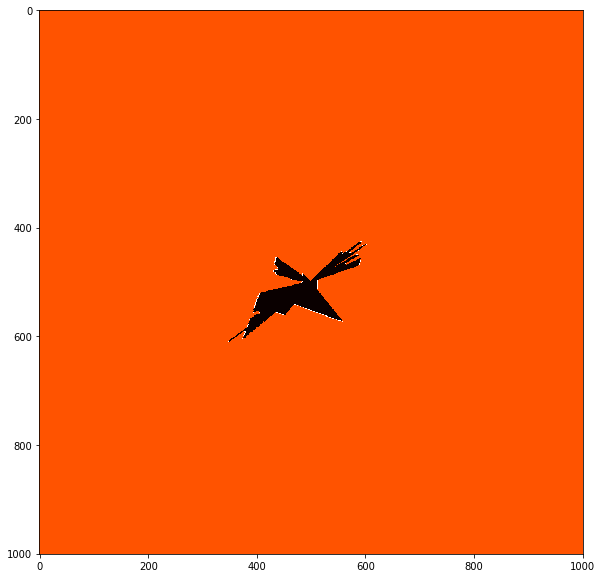

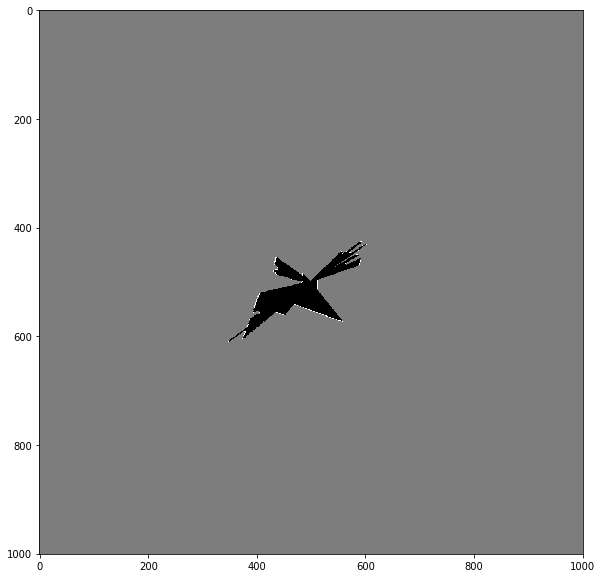

In [3]:
# Get path in pixel coordinates
x_path_is = np.ceil((np.array(x_path) - robot.fastslam.xmin) / robot.fastslam.map_res ).astype(np.int16)-1
y_path_is = np.ceil((np.array(y_path) - robot.fastslam.ymin) / robot.fastslam.map_res ).astype(np.int16)-1

# Get map output
slam_map = robot.get_map()

# Create threshold map
map_out = np.zeros(slam_map.shape).astype(np.uint8)
thresh = slam_map < 0.
map_out[thresh] = 0
thresh = slam_map > 0.
map_out[thresh] = 255
thresh = slam_map == 0.
map_out[thresh] = 125

# Plot outputs
plt.figure(figsize = (10,10))
plt.imshow(map_out,cmap="gray")
plt.plot(y_path_is,x_path_is,linewidth=2, color='blue')
plt.show()